In [122]:
import gen_wrangle as wrg
import scipy.stats as stats
import pandas as pd
import os
import numpy as np

# Data viz:
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn stuff:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor




import env

In [123]:
from pydataset import data
tips = data("tips")


In [124]:
tips["price_per_person"] = tips['total_bill'] / tips["size"]

In [125]:
tips_dummy=pd.get_dummies(tips[["day", "time"]], drop_first=True)

In [126]:
tips = pd.concat([tips, tips_dummy], axis=1)

In [127]:
tips["smoker_encoded"] = tips.smoker.map({"No":0, "Yes":1})
tips["sex_encoded"] = tips.sex.map({"Male":1, "Female":0}) 

In [128]:
train_tips, validate_tips, test_tips = wrg.split_function_cont_target(tips)

In [129]:
x_train, x_validate, x_test = train_tips[['total_bill', 'size', "day_Sat" , "day_Sun", "day_Thur" , "time_Lunch", "smoker_encoded", "sex_encoded" , "price_per_person"]], validate_tips[['total_bill', 'size', "day_Sat" , "day_Sun", "day_Thur" , "time_Lunch", "smoker_encoded", "sex_encoded" , "price_per_person"]], test_tips[['total_bill', 'size', "day_Sat" , "day_Sun", "day_Thur" , "time_Lunch", "smoker_encoded", "sex_encoded" , "price_per_person"]]

y_train, y_validate, y_test = train_tips.tip, validate_tips.tip, test_tips.tip 

In [130]:
def scale_data(train, validate, to_scale, test):
    #make copies for scaling
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()

    #this scales stuff 
    #make the thing
    scaler = MinMaxScaler()

    #fit the thing
    scaler.fit(train[to_scale])

    #use the thing
    train_scaled[to_scale] = scaler.transform(train[to_scale])
    validate_scaled[to_scale] = scaler.transform(validate[to_scale])
    test_scaled[to_scale] = scaler.transform(test[to_scale])
    
    return train_scaled, validate_scaled, test_scaled

#add in the test stuff. No modeling for this one so no test added 

In [131]:
to_scale=x_train.columns.tolist()

In [132]:
x_train_scaled, x_validate_scaled, x_test_scaled  = scale_data(x_train, x_validate,to_scale, x_test)

<function matplotlib.pyplot.show(close=None, block=None)>

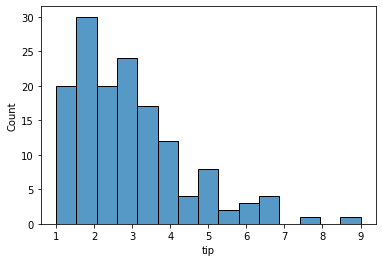

In [133]:
sns.histplot(y_train)
plt.show

In [134]:
baseline = y_train.mean()

In [135]:
baseline

2.9810958904109603

In [136]:
#base line is 2.98

In [137]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [138]:
#make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(train_tips))
baseline_array[:5]

array([2.98109589, 2.98109589, 2.98109589, 2.98109589, 2.98109589])

In [139]:
rmse, r2 = metrics_reg(y_train, baseline_array)

In [140]:
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

,model,rmse,r2
0,baseline,1.451105,2.220446e-16


In [141]:
#Ordinary Least Squares (OLS)

In [142]:
#select to top feature for OLS_1

In [143]:
#kbest
kbest = SelectKBest(f_regression, k=2) #makes the k best using f_regression model
kbest.fit(x_train_scaled, y_train) #fits it to x_train_scaled and y_train 

SelectKBest(k=2, score_func=<function f_regression at 0x7f84f270ad30>)

In [144]:
kbest_results = pd.DataFrame(dict(p_value=kbest.pvalues_, f_score=kbest.scores_), index=x_train_scaled.columns) 
#gets the p values and f score and saves to a dict then saves them to a DF with the index being the x_train column

In [145]:
kbest_results.sort_values(by=['f_score'], ascending=False) 


,p_value,f_score
total_bill,1.305620e-19,111.115028
size,3.669012e-12,57.607134
price_per_person,2.857090e-04,13.831878
day_Sun,7.197303e-02,3.285602
time_Lunch,1.411336e-01,2.189558
day_Thur,3.241839e-01,0.978682
sex_encoded,4.413546e-01,0.596049
smoker_encoded,7.716981e-01,0.084507
day_Sat,8.745567e-01,0.025013


In [146]:
#recursive feature elimination 

In [147]:
#set the model to linear regres
lr1 = LinearRegression()

# make it
rfe = RFE(lr1, n_features_to_select=1)

# fit it to the right things
rfe.fit(x_train_scaled, y_train)

x_train_rfe = rfe.transform(x_train_scaled)

x_validate_rfe = rfe.transform(x_validate_scaled)

x_test_rfe = rfe.transform(x_test_scaled)

In [148]:
#create a DF for the output
rfe_ranking = pd.DataFrame({'rfe_ranking': rfe.ranking_}, index=x_train_scaled.columns)
rfe_ranking.sort_values(by=['rfe_ranking'], ascending=True)

,rfe_ranking
total_bill,1
price_per_person,2
day_Sat,3
day_Thur,4
sex_encoded,5
time_Lunch,6
size,7
smoker_encoded,8
day_Sun,9


In [149]:
#build model
#fit the thing
lr1.fit(x_train_rfe, y_train)

#use the thing (make predictions)
pred_lr1 = lr1.predict(x_train_rfe)
pred_val_lr1 = lr1.predict(x_validate_rfe)

In [150]:
pred_lr1[:10]

array([2.37747501, 3.44395961, 5.70068838, 2.8176286 , 3.65381279,
       2.74337286, 3.48162557, 1.74145847, 4.68155526, 2.65943159])

In [151]:
#evaluate

In [152]:
#train
metrics_reg(y_train, pred_lr1)

(1.0902151104031415, 0.43554873651603543)

In [153]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr1)
rmse, r2

(1.0027134210017212, 0.5632480653696952)

In [154]:
#add to my metrics df
metrics_df.loc[1] = ['ols_1', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,1.451105,2.220446e-16
1,ols_1,1.002713,5.632481e-01


In [155]:
#multipule Regression 

In [156]:
#make it
lr2 = LinearRegression()

#fit it on our RFE features
lr2.fit(x_train, y_train)

#use it (make predictions)
pred_lr2 = lr2.predict(x_train)

#use it on validate
pred_val_lr2 = lr2.predict(x_validate)

In [157]:
pred_lr2[:10]

array([2.30602394, 3.2033402 , 5.51676009, 2.97436062, 3.25553438,
       2.70208873, 3.26503331, 1.70218038, 4.98373911, 2.66310318])

In [158]:
#evaluate

In [159]:
#train
metrics_reg(y_train, pred_lr2)

(1.0494223514205152, 0.4769988122083727)

In [160]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr2)
rmse, r2

(1.0678997212158647, 0.504615826198155)

In [161]:
metrics_df.loc[2] = ['ols', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,1.451105,2.220446e-16
1,ols_1,1.002713,5.632481e-01
2,ols,1.067900,5.046158e-01


In [162]:
#LassoLars

In [163]:
lars = LassoLars(alpha=1)

#fit it
lars.fit(x_train, y_train)

#use it
pred_lars = lars.predict(x_train)
pred_val_lars = lars.predict(x_validate)


In [164]:
pred_lars

array([2.98109589, 2.98109589, 2.98109589, 2.98109589, 2.98109589,
       2.98109589, 2.98109589, 2.98109589, 2.98109589, 2.98109589,
       2.98109589, 2.98109589, 2.98109589, 2.98109589, 2.98109589,
       2.98109589, 2.98109589, 2.98109589, 2.98109589, 2.98109589,
       2.98109589, 2.98109589, 2.98109589, 2.98109589, 2.98109589,
       2.98109589, 2.98109589, 2.98109589, 2.98109589, 2.98109589,
       2.98109589, 2.98109589, 2.98109589, 2.98109589, 2.98109589,
       2.98109589, 2.98109589, 2.98109589, 2.98109589, 2.98109589,
       2.98109589, 2.98109589, 2.98109589, 2.98109589, 2.98109589,
       2.98109589, 2.98109589, 2.98109589, 2.98109589, 2.98109589,
       2.98109589, 2.98109589, 2.98109589, 2.98109589, 2.98109589,
       2.98109589, 2.98109589, 2.98109589, 2.98109589, 2.98109589,
       2.98109589, 2.98109589, 2.98109589, 2.98109589, 2.98109589,
       2.98109589, 2.98109589, 2.98109589, 2.98109589, 2.98109589,
       2.98109589, 2.98109589, 2.98109589, 2.98109589, 2.98109

In [165]:
metrics_reg(y_train, pred_lars)

(1.451105446961829, 0.0)

In [166]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lars)
rmse, r2

(1.5258133479910245, -0.011309300681123569)

In [167]:
#add to my metrics df
metrics_df.loc[3] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,1.451105,2.220446e-16
1,ols_1,1.002713,5.632481e-01
2,ols,1.067900,5.046158e-01
3,lars,1.525813,-1.130930e-02


In [168]:
# make the polynomial features to get a new set of features
#at degree = 1 its just OLS
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
x_train_degree2 = pf.fit_transform(x_train)

# transform X_validate_scaled & X_test_scaled
x_validate_degree2 = pf.transform(x_validate)
x_test_degree2 = pf.transform(x_test)

In [169]:
#make it
pr = LinearRegression()

#fit it
pr.fit(x_train_degree2, y_train)

#use it
pred_pr = pr.predict(x_train_degree2)
pred_val_pr = pr.predict(x_validate_degree2)



In [170]:
#evaluating poly regs

In [171]:
#train
metrics_reg(y_train, pred_pr)

(0.7819506611940462, 0.7096239736790078)

In [172]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_pr)
rmse, r2

(1.938497110566104, -0.6323432874744135)

In [173]:
#add to my metrics df
metrics_df.loc[4] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,1.451105,2.220446e-16
1,ols_1,1.002713,5.632481e-01
2,ols,1.067900,5.046158e-01
3,lars,1.525813,-1.130930e-02
4,poly_2,1.938497,-6.323433e-01


In [174]:
#Generalized Linear Model (GLM)

In [202]:
#make it
glm = TweedieRegressor(power=1, alpha=2)

#fit it
glm.fit(x_train, y_train)

#use it
pred_glm = glm.predict(x_train)
pred_val_glm = glm.predict(x_validate)

In [203]:
#train
metrics_reg(y_train, pred_glm)


(1.0865418971805312, 0.43934588994409995)

In [204]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_glm)
rmse, r2

(0.9869739326711354, 0.5768517523779342)

In [205]:
metrics_df.loc[5] = ['glm',rmse,r2]
metrics_df

,model,rmse,r2
0,baseline,1.451105,2.220446e-16
1,ols_1,1.002713,5.632481e-01
2,ols,1.067900,5.046158e-01
3,lars,1.525813,-1.130930e-02
4,poly_2,1.938497,-6.323433e-01
5,glm,0.986974,5.768518e-01


In [206]:
#using ols_1 test
pred_test =glm.predict(x_test)
pred_test

array([4.99163659, 3.01829796, 4.52546301, 2.22301892, 2.97398613,
       4.17713925, 2.85946558, 2.56418722, 3.48257227, 2.74622997,
       2.24741786, 2.7189769 , 2.63703125, 2.41938131, 2.47605057,
       2.98525043, 2.23091662, 2.73494812, 6.04301105, 2.62271411,
       3.64179313, 2.48481561, 2.27337299, 2.93566079, 2.33767889,
       2.7825825 , 5.98022371, 4.96027072, 2.60361432, 2.36741804,
       3.80986984, 2.28838032, 3.86744086, 2.7722206 , 3.21938176,
       2.12645343, 2.46920766, 3.7513731 , 3.73111199, 2.4279469 ,
       2.88084092, 2.46812696, 2.81707992, 2.58612048, 5.54992265,
       3.12025901, 2.21272358, 3.19451134, 2.01082368])

In [207]:
rmse, r2 = metrics_reg(y_test, pred_test)
rmse, r2

(0.8360576164612488, 0.21249572358091917)

In [208]:
#actual v. predicted 

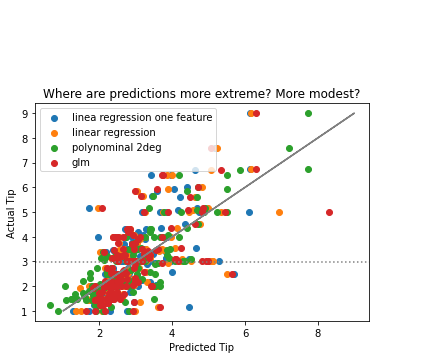

In [191]:
plt.scatter(pred_lr1, y_train, label="linea regression one feature")
plt.scatter(pred_lr2, y_train, label='linear regression')
plt.scatter(pred_pr, y_train, label='polynominal 2deg')
plt.scatter(pred_glm, y_train, label='glm')
plt.plot(y_train, y_train, label='_nolegend_', color='grey')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate("Baseline", (10, 13))

plt.title("Where are predictions more extreme? More modest?")
plt.ylabel("Actual Tip")
plt.xlabel("Predicted Tip")
plt.legend()

plt.show()

In [ ]:
#plotting the residuals

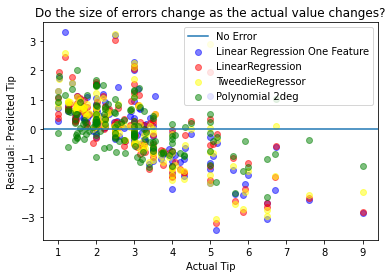

In [209]:
plt.axhline(label="No Error")

plt.scatter(y_train, pred_lr1 - y_train, alpha=.5, color="blue", label="Linear Regression One Feature")
plt.scatter(y_train, pred_lr2 - y_train, alpha=.5, color="red", label="LinearRegression")
plt.scatter(y_train, pred_glm - y_train, alpha=.5, color="yellow", label="TweedieRegressor")
plt.scatter(y_train, pred_pr - y_train, alpha=.5, color="green", label="Polynomial 2deg ")

plt.legend()
plt.title("Do the size of errors change as the actual value changes?")
plt.xlabel("Actual Tip")
plt.ylabel("Residual: Predicted Tip")

plt.show()